# Outlining some pre-processing

In [1]:
%load_ext jupyter_black
import os
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [2]:
# gis_dir = Path(os.getenv("STORM_DATA_DIR")) / "gis files/"
input_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input/02_housing_damage/input/"
)
output_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input/02_housing_damage/output/"
)
adm3_shp = gpd.read_file(input_dir / "phl_adminboundaries_candidate_adm3.zip")

In [3]:
phl_north_bld = gpd.read_file(
    input_dir / "hotosm_phl_north_buildings_polygons_shp.zip"
)
phl_south_bld = gpd.read_file(
    input_dir / "hotosm_phl_south_buildings_polygons_shp.zip"
)

In [4]:
phl_bld = pd.concat([phl_north_bld, phl_south_bld])

<AxesSubplot: >

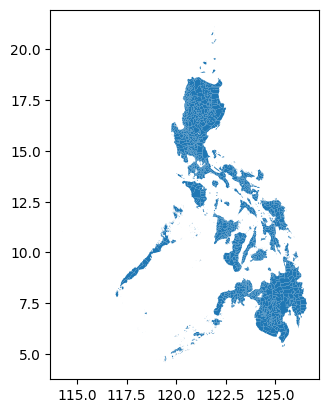

In [5]:
adm3_shp.loc[:, "geometry"].plot()

## Creation of grid

In [8]:
# grid creation
xmin, xmax, ymin, ymax = 114.25, 126.75, 4.55, 21.15

cell_size = 0.1

cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))
rows.reverse()
# using list comprehension instead of loop
polygons = [
    Polygon(
        [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y - cell_size),
            (x, y - cell_size),
        ]
    )
    for x in cols
    for y in rows
]
grid = gpd.GeoDataFrame({"geometry": polygons}, crs=adm3_shp.crs)
grid["id"] = grid.index + 1
# grid.to_crs(epsg=4326, inplace=True)
grid.head()

geometry  id
0  POLYGON ((114.25000 21.15000, 114.35000 21.150...   1
1  POLYGON ((114.25000 21.05000, 114.35000 21.050...   2
2  POLYGON ((114.25000 20.95000, 114.35000 20.950...   3
3  POLYGON ((114.25000 20.85000, 114.35000 20.850...   4
4  POLYGON ((114.25000 20.75000, 114.35000 20.750...   5

<AxesSubplot: >

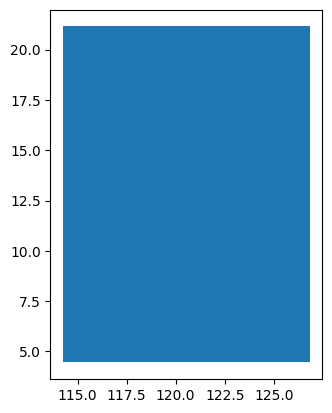

In [10]:
grid.loc[:, "geometry"].plot()

In [ ]:
# write as geopackage
grid.to_file(output_dir / "phl_0.1_degree_grid.gpkg", driver="GPKG")

## Creation of centroids

In [11]:
# creating centroids
# Grid
# Extract lat and lon from the centerpoint
grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)
grid["Centroid"] = (
    round(grid["Longitude"], 2).astype(str)
    + "E"
    + "_"
    + +round(grid["Latitude"], 2).astype(str)
    + "N"
)
grid.head(5)

C:\Users\pauni\AppData\Local\Temp\ipykernel_34812\2061595231.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
C:\Users\pauni\AppData\Local\Temp\ipykernel_34812\2061595231.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)


geometry  id  Longitude  Latitude  \
0  POLYGON ((114.25000 21.15000, 114.35000 21.150...   1  114.30000  21.10000   
1  POLYGON ((114.25000 21.05000, 114.35000 21.050...   2  114.30000  21.00000   
2  POLYGON ((114.25000 20.95000, 114.35000 20.950...   3  114.30000  20.90000   
3  POLYGON ((114.25000 20.85000, 114.35000 20.850...   4  114.30000  20.80000   
4  POLYGON ((114.25000 20.75000, 114.35000 20.750...   5  114.30000  20.70000   

       Centroid  
0  114.3E_21.1N  
1  114.3E_21.0N  
2  114.3E_20.9N  
3  114.3E_20.8N  
4  114.3E_20.7N

C:\Users\pauni\AppData\Local\Temp\ipykernel_34812\710311070.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids["geometry"] = grid_centroids["geometry"].centroid


<AxesSubplot: >

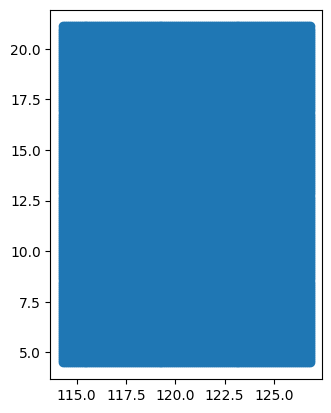

In [12]:
# Centroids
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids["geometry"].centroid
grid_centroids.loc[:, "geometry"].plot()

In [ ]:
# write as geopackage
grid_centroids.to_file(
    output_dir / "phl_0.1_degree_grid_centroids.gpkg", driver="GPKG"
)

In [13]:
# building centroids
phl_bld_centroids = phl_bld.copy()
phl_bld_centroids["geometry"] = phl_bld_centroids["geometry"].centroid

C:\Users\pauni\AppData\Local\Temp\ipykernel_34812\1346171841.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  phl_bld_centroids["geometry"] = phl_bld_centroids["geometry"].centroid


In [ ]:
phl_bld_centroids.to_file(input_dir / "phl_bld_centroids.gpkg", driver="GPKG")

## Intersection of grid and admin shapefile

(124.0, 126.0, 10.0, 11.0)

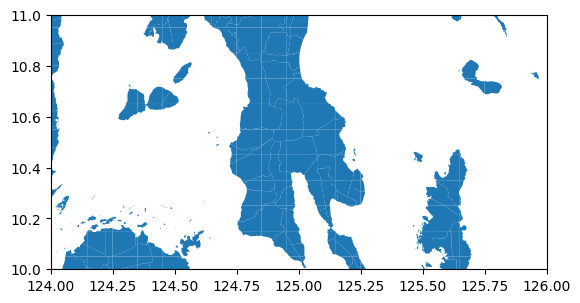

In [14]:
# intersection of grid and shapefile
adm3_grid_intersection = gpd.overlay(adm3_shp, grid, how="identity")
# adm3_grid_intersection = gpd.sjoin(adm3_shp, grid)
adm3_grid_intersection.loc[:, "geometry"].plot()
plt.axis([124, 126, 10, 11])

In [15]:
adm3_grid_intersection = adm3_grid_intersection.dropna(subset=["id"])

In [ ]:

adm3_grid_intersection.to_file(
    input_dir / "phl_adm3_grid_intersection.gpkg", driver="GPKG"
)

### For only grids that overlap with land

In [16]:
grid_land_overlap = grid.loc[grid["id"].isin(adm3_grid_intersection["id"])]

In [ ]:
grid_land_overlap.to_file(
    output_dir / "phl_0.1_degree_grid_land_overlap.gpkg", driver="GPKG"
)

In [17]:
grid_land_overlap_centroids = grid_centroids.loc[
    grid["id"].isin(adm3_grid_intersection["id"])
]

In [ ]:
grid_land_overlap_centroids.to_file(
    output_dir / "phl_0.1_degree_grid_centroids_land_overlap.gpkg",
    driver="GPKG",
)

## Area Computation

In [18]:
# computing areas
adm3_shp_area = adm3_shp.copy()
adm3_shp_area = adm3_shp_area.to_crs({"proj": "cea"})
adm3_shp_area["Area"] = adm3_shp_area["geometry"].area
adm3_shp_area["Area"].describe()

count         1647.00000
mean     178203548.62475
std      205850893.13715
min         399814.39589
25%       59475704.69187
50%      112122826.18895
75%      217178925.81056
max     2341425972.12693
Name: Area, dtype: float64

In [ ]:
adm3_shp_area.to_csv(input_dir / "adm3_area.csv")

In [19]:
grid_area = grid.copy()
grid_area = grid_area.to_crs({"proj": "cea"})
grid_area["Area_2"] = grid_area["geometry"].area
grid_area["Area_2"].describe()

count       21042.00000
mean    119695120.29336
std       2264611.78639
min     115037429.58114
25%     117847062.92781
50%     120110742.24897
75%     121743165.74512
max     122721372.36749
Name: Area_2, dtype: float64

In [20]:
adm3_grid_intersection_area = adm3_grid_intersection.copy()
adm3_grid_intersection_area = adm3_grid_intersection_area.to_crs(
    {"proj": "cea"}
)
adm3_grid_intersection_area["Area_3"] = adm3_grid_intersection_area[
    "geometry"
].area
adm3_grid_intersection_area["Area_3"].describe()

count        9887.00000
mean     29685571.41553
std      32217834.66106
min             0.00000
25%       3976912.50393
50%      17316476.08919
75%      45865982.27149
max     122477314.28712
Name: Area_3, dtype: float64

In [21]:
# merge
phl_adm3_grid_intersections_area = adm3_shp_area.merge(
    grid_area.merge(
        adm3_grid_intersection_area, on="id", suffixes=(None, "_3")
    ),
    on="ADM3_PCODE",
    suffixes=(None, "_2"),
)

phl_adm3_grid_intersections_area.drop(
    phl_adm3_grid_intersections_area.filter(regex="geometry").columns,
    axis=1,
    inplace=True,
)

In [ ]:
phl_adm3_grid_intersections_area.to_csv(
    input_dir / "phl_adm3_grid_intersections_area.csv"
)

## Building Count

### Assigning Buildings to Grids

In [22]:
phl_bld_centroid_grid_count = grid_land_overlap.merge(
    grid_land_overlap.sjoin(phl_bld_centroids, how="left")
    .groupby("id")
    .count()
    .geometry.rename("numbuildings")
    .reset_index()
)

In [ ]:
phl_bld_centroid_grid_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_grid_count.csv"
)

In [23]:
phl_bld_centroid_grid_count.head(8)

geometry    id  Longitude  \
0  POLYGON ((114.25000 11.15000, 114.35000 11.150...   101  114.30000   
1  POLYGON ((116.85000 7.95000, 116.95000 7.95000...  4475  116.90000   
2  POLYGON ((116.95000 8.25000, 117.05000 8.25000...  4639  117.00000   
3  POLYGON ((116.95000 8.15000, 117.05000 8.15000...  4640  117.00000   
4  POLYGON ((116.95000 8.05000, 117.05000 8.05000...  4641  117.00000   
5  POLYGON ((116.95000 7.95000, 117.05000 7.95000...  4642  117.00000   
6  POLYGON ((116.95000 7.85000, 117.05000 7.85000...  4643  117.00000   
7  POLYGON ((117.05000 8.35000, 117.15000 8.35000...  4805  117.10000   

   Latitude      Centroid  numbuildings  
0  11.10000  114.3E_11.1N             1  
1   7.90000   116.9E_7.9N             1  
2   8.20000   117.0E_8.2N             1  
3   8.10000   117.0E_8.1N             3  
4   8.00000   117.0E_8.0N           124  
5   7.90000   117.0E_7.9N            91  
6   7.80000   117.0E_7.8N            37  
7   8.30000   117.1E_8.3N             1

In [24]:
phl_bld_centroid_grid_count["numbuildings"].sum()

10338646

### Testing new way of counting buildings

In [25]:
# assigning buildings to municipalities
phl_bld_centroid_municip_count = adm3_shp.merge(
    adm3_shp.sjoin(phl_bld_centroids, how="left")
    .groupby("ADM3_PCODE")
    .count()
    .osm_id.rename("numbuildings")
    .reset_index()
)

In [26]:
phl_bld_centroid_municip_count["numbuildings"].sum()

10324006

In [27]:
phl_bld_centroid_municip_count[
    phl_bld_centroid_municip_count["ADM3_PCODE"] == "PH157005000"
]

Shape_Leng  Shape_Area    ADM3_EN   ADM3_PCODE ADM3_REF ADM3ALT1EN  \
1470     1.08053     0.00227  Sitangkai  PH157005000     None       None   

     ADM3ALT2EN    ADM2_EN   ADM2_PCODE                               ADM1_EN  \
1470       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   

       ADM1_PCODE            ADM0_EN ADM0_PCODE        date     validOn  \
1470  PH150000000  Philippines (the)         PH  2016-06-30  2020-05-29   

     validTo                                           geometry  numbuildings  
1470    None  MULTIPOLYGON (((119.38935 4.61459, 119.38928 4...             0

In [ ]:
phl_bld_centroid_municip_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_municip_count.csv"
)

In [28]:
phl_bld_centroid_municip_count["numbuildings"].sum()
len(phl_bld_centroid_municip_count["ADM3_PCODE"].unique())

1647

In [29]:
# assigning buildings to intersections
phl_bld_centroid_municip_intersection_count = adm3_grid_intersection.merge(
    adm3_grid_intersection.sjoin(phl_bld_centroids, how="left")
    .groupby(["ADM3_PCODE", "Centroid"])
    .count()
    .osm_id.rename("numbuildings")
    .reset_index()
)

In [30]:
phl_bld_centroid_municip_intersection_count[
    phl_bld_centroid_municip_intersection_count["ADM3_PCODE"] == "PH157005000"
]

Shape_Leng  Shape_Area    ADM3_EN   ADM3_PCODE ADM3_REF ADM3ALT1EN  \
9711     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9743     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9744     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9745     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9746     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9747     1.08053     0.00227  Sitangkai  PH157005000     None       None   
9748     1.08053     0.00227  Sitangkai  PH157005000     None       None   

     ADM3ALT2EN    ADM2_EN   ADM2_PCODE                               ADM1_EN  \
9711       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9743       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9744       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9745       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9746       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9747       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   
9748       None  Tawi-Tawi  PH157000000  Autonomous Region in Muslim Mindanao   

      ... ADM0_PCODE        date     validOn validTo         id Longitude  \
9711  ...         PH  2016-06-30  2020-05-29    None 8680.00000 119.40000   
9743  ...         PH  2016-06-30  2020-05-29    None 8014.00000 119.00000   
9744  ...         PH  2016-06-30  2020-05-29    None 8181.00000 119.10000   
9745  ...         PH  2016-06-30  2020-05-29    None 8348.00000 119.20000   
9746  ...         PH  2016-06-30  2020-05-29    None 8681.00000 119.40000   
9747  ...         PH  2016-06-30  2020-05-29    None 8682.00000 119.40000   
9748  ...         PH  2016-06-30  2020-05-29    None 8683.00000 119.40000   

      Latitude     Centroid  \
9711   4.90000  119.4E_4.9N   
9743   4.70000  119.0E_4.7N   
9744   4.70000  119.1E_4.7N   
9745   4.70000  119.2E_4.7N   
9746   4.80000  119.4E_4.8N   
9747   4.70000  119.4E_4.7N   
9748   4.60000  119.4E_4.6N   

                                               geometry numbuildings  
9711  MULTIPOLYGON (((119.41227 4.86660, 119.41228 4...            0  
9743  POLYGON ((119.03222 4.70844, 119.03206 4.70844...            0  
9744  POLYGON ((119.14656 4.72232, 119.14661 4.72232...            0  
9745  MULTIPOLYGON (((119.23775 4.72623, 119.23771 4...            0  
9746  MULTIPOLYGON (((119.42215 4.78781, 119.42215 4...            0  
9747  MULTIPOLYGON (((119.42006 4.74995, 119.42008 4...            0  
9748  MULTIPOLYGON (((119.39220 4.64999, 119.39222 4...            0  

[7 rows x 22 columns]

In [ ]:
phl_bld_centroid_municip_intersection_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_municip_intersection_count.csv"
)

In [31]:
phl_bld_centroid_municip_intersection_count.shape
len(phl_bld_centroid_municip_intersection_count["ADM3_PCODE"].unique())

1647

In [32]:
phl_bld_centroid_municip_intersection_count["numbuildings"].sum()

10324006

In [33]:
phl_bld_weight_matrix = phl_bld_centroid_municip_count.merge(
    phl_bld_centroid_municip_intersection_count,
    on="ADM3_PCODE",
    suffixes=(None, "_y"),
)
phl_bld_weight_matrix["weight"] = np.where(
    phl_bld_weight_matrix["numbuildings_y"] == 0,
    0,
    phl_bld_weight_matrix["numbuildings_y"]
    / phl_bld_weight_matrix["numbuildings"],
)

In [34]:
phl_bld_weight_matrix["weight"].describe()

count   9887.00000
mean       0.16598
std        0.24905
min        0.00000
25%        0.00036
50%        0.04117
75%        0.22206
max        1.00000
Name: weight, dtype: float64

In [ ]:
phl_bld_weight_matrix[
    ["ADM3_PCODE", "ADM3_EN", "id", "Centroid", "weight"]
].to_csv(input_dir / "phl_bld_weight_matrix.csv")